In [3]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import math
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u

cosmo = FlatLambdaCDM(H0=72, Om0=0.3)

In [4]:
hdulist = fits.open('../petroC_nsa_gzoo.fits')
tbdata = hdulist[1].data
color = tbdata['col10'] #^{0.1}(g-r), K-E corrected to z=0.1, petro
M_r = tbdata['col9'] #^{0.1}(M_r) - 5\log h, K-E corrected to z=0.1, petro
pfeatures = tbdata['t01_smooth_or_features_a02_features_or_disk_weighted_fraction']
psmooth = tbdata['t01_smooth_or_features_a01_smooth_weighted_fraction']
sSFR = tbdata['B300']
HA = tbdata['HAFLUX']
HB = tbdata['HBFLUX']
O3 = tbdata['O3FLUX']
N2 = tbdata['N2FLUX']
D4000 = tbdata['D4000']
z = tbdata['Z']
hdulist.close()

In [15]:
i=0
while i < 1000:
    if D4000[i] > 0:
        print math.log(D4000[i],10)
    i+=1

0.287613615093
0.212399403515
0.233122534197
0.0761021097337
0.290373609102
0.192660079204
0.130536636418
0.110173797808
0.280213179565
0.182799085273
0.235703269626
0.0902595060759
0.105551511021
0.0865513972049
0.24476703935
0.103837915178
0.184404382742
0.196724530031
0.264610102598
0.226793139603
0.186185161432
0.273989639412
0.153267575478
0.246502028957
0.1595150255
0.222009523489
0.0651001877913
0.105955349494
0.173347394482
0.101647921336
0.119238810183
0.17305272076
0.124245488029
0.310318383501
0.0816250853743
0.176115591184
0.103214255927
0.130849425199
0.295778388156
0.273738182622
0.234290636839
0.272173043021
0.0829900274693
0.0714424061209
0.217450018151
0.26875312855
0.0776900905301
0.116586082196
0.177443643141
0.118850686086
0.272095963143
0.300050505885
0.242324163321
0.299287615214
0.260933031511
0.0799631780706
0.0743636663831
0.0567926588672
0.213322053619
0.164571707983
0.0894598196771
0.128733417664
0.0983160967089
0.142265318668
0.288890789164
0.151904465973
0.

In [5]:
early_pfeatures = []
early_psmooth = []
early_color = []
early_sfr = []
early_mr = []

late_pfeatures = []
late_psmooth = []
late_color = []
late_sfr = []
late_mr = []

int_pfeatures = []
int_psmooth = []
int_color = []
int_sfr = []
int_mr = []

for i in np.arange(pfeatures.size):
    if z[i] > 0.01 and z[i] < 0.06 and HA[i] > 0 and HB[i] > 0:
        color_line = 0.7 - 0.032*(M_r[i] + 16.5)
        active_line = -10 + 0.094*(M_r[i] + 15)
    
        #Convert fluxes to luminosities
        FHA = HA[i]*(10**-17)*u.erg / u.s / u.cm**2
        FHA = FHA.to(u.W/(u.pc**2))
        LHA = cosmo.luminosity_distance(z[i]).to(u.pc)**2 * 4 * math.pi * FHA
        
        FHB = HB[i]*(10**-17)*u.erg / u.s / u.cm**2
        FHB = FHB.to(u.W/(u.pc**2))
        LHB = cosmo.luminosity_distance(z[i]).to(u.pc)**2 * 4 * math.pi * FHB
        
        FO3 = O3[i]*(10**-17)*u.erg / u.s / u.cm**2
        FO3 = FO3.to(u.W/(u.pc**2))
        LO3 = cosmo.luminosity_distance(z[i]).to(u.pc)**2 * 4 * math.pi * FO3
        
        FN2 = N2[i]*(10**-17)*u.erg / u.s / u.cm**2
        FN2 = FN2.to(u.W/(u.pc**2))
        LN2 = cosmo.luminosity_distance(z[i]).to(u.pc)**2 * 4 * math.pi * FN2
        
        if LHA > 0 and LHB > 0 and LO3 > 0 and LN2 > 0:
            if math.log(LO3/LHB, 10) > 0.61/(math.log(LN2/LHA, 10) - 0.05) + 1.3: #galaxies that lie above Kauffman BPT line
                logsSFR = D4000[i]
            else:
                LHA_c = LHA*(((LHA/LHB)/2.8)**2.36) #corrected HA luminosity from Spindler et. al. 2017
                logsSFR = math.log(LHA_c.value) - 41.1 #SFR calculated using Halpha flux from Spindler et al 2017
            if color[i] >= color_line: #red galaxies
                if logsSFR <= active_line: #passive galaxies - early type
                    early_pfeatures.append(pfeatures[i])
                    early_psmooth.append(psmooth[i])
                    early_color.append(color[i])
                    early_sfr.append(logsSFR)
                    early_mr.append(M_r[i])
                else: #red and active - intermediate type
                    int_pfeatures.append(pfeatures[i])
                    int_psmooth.append(pfeatures[i])
                    int_color.append(color[i])
                    int_sfr.append(logsSFR)
                    int_mr.append(M_r[i])
            elif logsSFR >= active_line: #blue and active - late type
                late_pfeatures.append(pfeatures[i])
                late_psmooth.append(psmooth[i])
                late_color.append(color[i])
                late_sfr.append(logsSFR)
                late_mr.append(M_r[i])

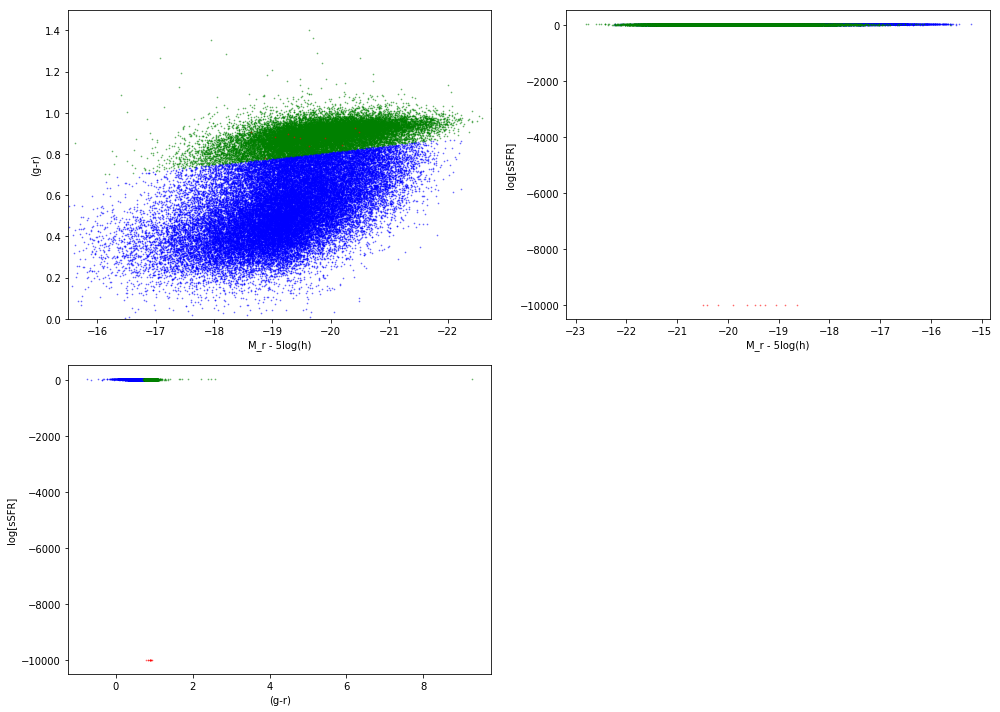

In [7]:
fig = plt.figure(figsize=(14,10))

colors = [late_color, int_color, early_color]
mrs = [late_mr, int_mr, early_mr]
sfrs = [late_sfr, int_sfr, early_sfr]
plot_color = ['b', 'g', 'r']

#top left plot
ax1 = fig.add_subplot(221)
for i in np.arange(3):
    ax1.scatter(mrs[i], colors[i], color = plot_color[i], s=0.5, alpha=0.5)
ax1.set_ylabel('(g-r)')
ax1.set_xlabel('M_r - 5log(h)')
ax1.set_ylim(0, 1.5)
ax1.set_xlim(-15.5, -22.75)

#top right plot
ax2 = fig.add_subplot(222)
for i in np.arange(3):
    ax2.scatter(mrs[i], sfrs[i], color = plot_color[i], s=0.5, alpha=0.5)
ax2.set_ylabel('log[sSFR]')
ax2.set_xlabel('M_r - 5log(h)')
#ax2.set_ylim(-12, -9.5)
#ax2.set_xlim(-15.5, -22.75)

#bottom left plot
ax3 = fig.add_subplot(223)
for i in np.arange(3):
    ax3.scatter(colors[i], sfrs[i], color = plot_color[i], s=0.5, alpha=0.5)
ax3.set_ylabel('log[sSFR]')
ax3.set_xlabel('(g-r)')
#ax3.set_ylim(-12, -9.5)
#ax3.set_xlim(0,1.5)

plt.tight_layout()
plt.show()

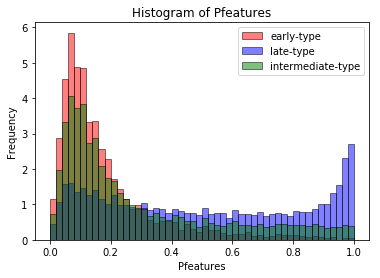

In [5]:
plt.hist(early_pfeatures, 50, normed=1, facecolor='r', alpha=0.5, ec='black', label='early-type')
plt.hist(late_pfeatures, 50, normed=1, facecolor='b', alpha=0.5, ec='black', label='late-type')
plt.hist(int_pfeatures, 50, normed=1, facecolor='g', alpha=0.5, ec='black', label='intermediate-type')
plt.xlabel('Pfeatures')
plt.ylabel('Frequency')
plt.title('Histogram of Pfeatures')
plt.legend(loc='upper right')
plt.show()

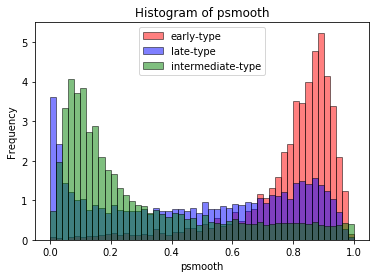

In [6]:
plt.hist(early_psmooth, 50, normed=1, facecolor='r', alpha=0.5, ec='black', label='early-type')
plt.hist(late_psmooth, 50, normed=1, facecolor='b', alpha=0.5, ec='black', label='late-type')
plt.hist(int_psmooth, 50, normed=1, facecolor='g', alpha=0.5, ec='black', label='intermediate-type')
plt.xlabel('psmooth')
plt.ylabel('Frequency')
plt.title('Histogram of psmooth')
plt.legend(loc='upper center')
plt.show()